In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from functools import reduce
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF


#### 데이터 준비

In [3]:
df = pd.read_csv('/home/user/exercise_j/TwitterXAPI/10000Tweets_Crypto_data.csv')

In [4]:
df['created_at'] = pd.to_datetime(df['created_at'])
df.sort_values(by='created_at', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,created_at,text,ticker,sentiment_score
0,2010-10-30,Absolutely Stunning Vector Inspiration http://...,BTC,0.00
1,2010-11-01,@yogavenger Thanks for the RTs,BTC,0.75
2,2010-11-03,Massive Social Media Icon Collection http://bi...,BTC,0.00
3,2010-11-04,Is the User Mastermind Behind Web Design? http...,BTC,0.00
4,2010-11-05,Everyone give a big happy birthday to @robertb...,BTC,0.00


#### (가장 데이터가 많이 존재하는)최근 6개월의 데이터로 input_data 설정
##### 2023.06.01 ~ 2023.12.31

In [5]:
start_date = '2023-06-01'
end_date = '2023-12-31'
filtered_df = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])
filtered_df

,created_at,text,ticker,sentiment_score
0,2023-06-01,The Fed and Treasury are using interest income...,BTC,0.8
1,2023-06-01,RT @vdWijden: Are you interested in core devel...,ETH,0.0
2,2023-06-01,RT @TMIYChao: Ethereum is for everyone and the...,ETH,0.0
3,2023-06-01,@gregthegreek Maybe we should just airdrop (bi...,ETH,0.0
4,2023-06-02,@lightclients There might be too much alpha in...,ETH,0.0
...,...,...,...,...
4437,2023-12-31,RT @xrpmemeguy: Do you know why Patrick McHenr...,XRP,0.0
4438,2023-12-31,"XRP ETF / Ripple Win , United States Of Corrup...",XRP,0.0
4439,2023-12-31,"RT @zerohedge: ""We Are Going To See 'Collision...",BTC,0.0
4440,2023-12-31,My Theory: FTX was created for the specific pu...,SOL,-1.0


1. 티커별로 분류
2. 각 티커별로 input_data 생성
 - input_data의 구성은 created_at sentiment_score

In [6]:
# 1. 티커별로 데이터프레임을 분류
tickers = filtered_df['ticker'].unique()
ticker_dfs = {ticker: filtered_df[filtered_df['ticker'] == ticker] for ticker in tickers}

# 2. 각 티커에 대한 input_data를 생성
# input_data는 'created_at'과 'sentiment_score'만 포함
input_data = {ticker: filtered_df[['created_at', 'sentiment_score']] for ticker, filtered_df in ticker_dfs.items()}

input_data['ETH'] 

,created_at,sentiment_score
1,2023-06-01,0.00
2,2023-06-01,0.00
3,2023-06-01,0.00
4,2023-06-02,0.00
11,2023-06-05,0.25
...,...,...
4400,2023-12-30,-0.50
4411,2023-12-30,-0.60
4419,2023-12-30,-0.50
4427,2023-12-31,0.00


In [7]:
grouped_input_data = {}
for ticker, df in ticker_dfs.items():
    grouped_df = df.groupby('created_at')['sentiment_score'].sum().reset_index()
    grouped_input_data[ticker] = grouped_df

grouped_input_data

{'BTC':     created_at  sentiment_score
 0   2023-06-01             0.80
 1   2023-06-04             0.00
 2   2023-06-06             1.50
 3   2023-06-07             0.00
 4   2023-06-09             0.00
 ..         ...              ...
 175 2023-12-27             1.65
 176 2023-12-28            -0.50
 177 2023-12-29             0.10
 178 2023-12-30            -1.00
 179 2023-12-31             0.45
 
 [180 rows x 2 columns],
 'ETH':     created_at  sentiment_score
 0   2023-06-01             0.00
 1   2023-06-02             0.00
 2   2023-06-05             0.50
 3   2023-06-06             0.50
 4   2023-06-08             5.95
 ..         ...              ...
 171 2023-12-27            -1.65
 172 2023-12-28             0.00
 173 2023-12-29            -2.00
 174 2023-12-30            -1.60
 175 2023-12-31            -0.50
 
 [176 rows x 2 columns],
 'UNI':    created_at  sentiment_score
 0  2023-06-02            -1.00
 1  2023-06-03            -0.75
 2  2023-06-04             0.80
 3  2

#### 각 크립토 거래 종가, 거래 규모 데이터 (2023.06.01 ~ 2023.12.31)

In [8]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

In [9]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    del df['변동 %']
    del df['고가']
    del df['시가']
    del df['저가']
    
    # 날짜 열을 datetime 객체로 변환
    df['created_at'] = pd.to_datetime(df['날짜'])
    del df['날짜']

    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2


In [10]:
filtered_dfs['ETH']

,종가,거래량,created_at
0,"2,281.90",232.62K,2023-12-31
1,"2,291.70",219.92K,2023-12-30
2,"2,299.24",475.37K,2023-12-29
3,"2,344.47",626.91K,2023-12-28
4,"2,378.63",577.27K,2023-12-27
...,...,...,...
209,"1,811.20",588.61K,2023-06-05
210,"1,890.04",183.07K,2023-06-04
211,"1,892.05",157.10K,2023-06-03
212,"1,907.10",329.16K,2023-06-02


#### (${p_t}, {v_t}, {s_t}$) 만들기

In [11]:
print(grouped_input_data.keys())
print(filtered_dfs.keys())

dict_keys(['BTC', 'ETH', 'UNI', 'BNB', 'DOT', 'XRP', 'SOL', 'FTT'])
dict_keys(['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP', 'UNI'])


In [12]:
def convert_volume(volume):
    if isinstance(volume, str):  # volume이 문자열인지 확인
        if 'K' in volume:
            return float(volume.replace('K', '')) * 1000
        elif 'M' in volume:
            return float(volume.replace('M', '')) * 1000000
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1000000000
        else:
            return float(volume)
    else:
        return volume

In [13]:
merged_dfs = {}
for ticker in ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP','UNI']:
    merged_df = pd.merge(filtered_dfs[ticker], grouped_input_data[ticker], on='created_at', how='outer')
    merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0.0)
    merged_df['거래량'] = merged_df['거래량'].apply(convert_volume)
    merged_dfs[ticker] = merged_df

# 결과 출력
merged_dfs

{'BTC':            종가      거래량 created_at  sentiment_score
 0    42,272.5  35580.0 2023-12-31             0.45
 1    42,136.7  35180.0 2023-12-30            -1.00
 2    42,072.4  60980.0 2023-12-29             0.10
 3    42,581.1  49840.0 2023-12-28            -0.50
 4    43,446.5  50100.0 2023-12-27             1.65
 ..        ...      ...        ...              ...
 209  25,747.4  85420.0 2023-06-05             0.00
 210  27,122.3  23810.0 2023-06-04             0.00
 211  27,072.0  20620.0 2023-06-03             0.00
 212  27,244.7  49370.0 2023-06-02             0.00
 213  26,819.0  51980.0 2023-06-01             0.80
 
 [214 rows x 4 columns],
 'ETH':            종가       거래량 created_at  sentiment_score
 0    2,281.90  232620.0 2023-12-31            -0.50
 1    2,291.70  219920.0 2023-12-30            -1.60
 2    2,299.24  475370.0 2023-12-29            -2.00
 3    2,344.47  626910.0 2023-12-28             0.00
 4    2,378.63  577270.0 2023-12-27            -1.65
 ..        ...   

#### 각 티커별 데이터 변환 및 스케일링

In [14]:
scaler = MinMaxScaler()

In [15]:
processed_data = {}

for ticker, df in merged_dfs.items():
    # '종가' 열 처리: 쉼표 제거, 실수형 변환
    prices = df['종가'].replace(',', '', regex=True).astype(float).values.reshape(-1, 1)

    # '거래량' 열 처리
    volumes = df['거래량'].values.reshape(-1, 1)

    # 'sentiment_score' 열 처리
    sentiments = df['sentiment_score'].values.reshape(-1, 1)

    # (p_t, v_t, s_t) 형태로 결합
    data = np.hstack((prices, volumes, sentiments))
    # 데이터를 표준화
    data = scaler.fit_transform(data)
    
    processed_data[ticker] = data


processed_data['ETH']

array([[0.88469837, 0.1471602 , 0.23255814],
       [0.89637991, 0.13607846, 0.10465116],
       [0.90536755, 0.35897839, 0.05813953],
       [0.95928147, 0.49120878, 0.29069767],
       [1.        , 0.44789403, 0.09883721],
       [0.82371592, 0.31895326, 0.29069767],
       [0.87215858, 0.20435765, 0.29069767],
       [0.86284911, 0.22282139, 0.1744186 ],
       [0.91653654, 0.17654861, 0.23255814],
       [0.9351555 , 0.48581625, 0.79651163],
       [0.83430084, 0.35556661, 0.85465116],
       [0.78968448, 0.32842072, 0.3372093 ],
       [0.76018261, 0.29403244, 0.        ],
       [0.80948351, 0.28296816, 0.23255814],
       [0.78354571, 0.14791061, 0.11627907],
       [0.82172529, 0.12462152, 0.16860465],
       [0.81140262, 0.24926049, 0.37790698],
       [0.92491626, 0.34696299, 0.29069767],
       [0.85880824, 0.32518346, 0.29069767],
       [0.79123407, 0.27318657, 0.90697674],
       [0.81727915, 0.53581494, 0.25581395],
       [0.9685671 , 0.12461279, 0.29069767],
       [0.

#### 데이터셋 산포도(scatter plot) 확인

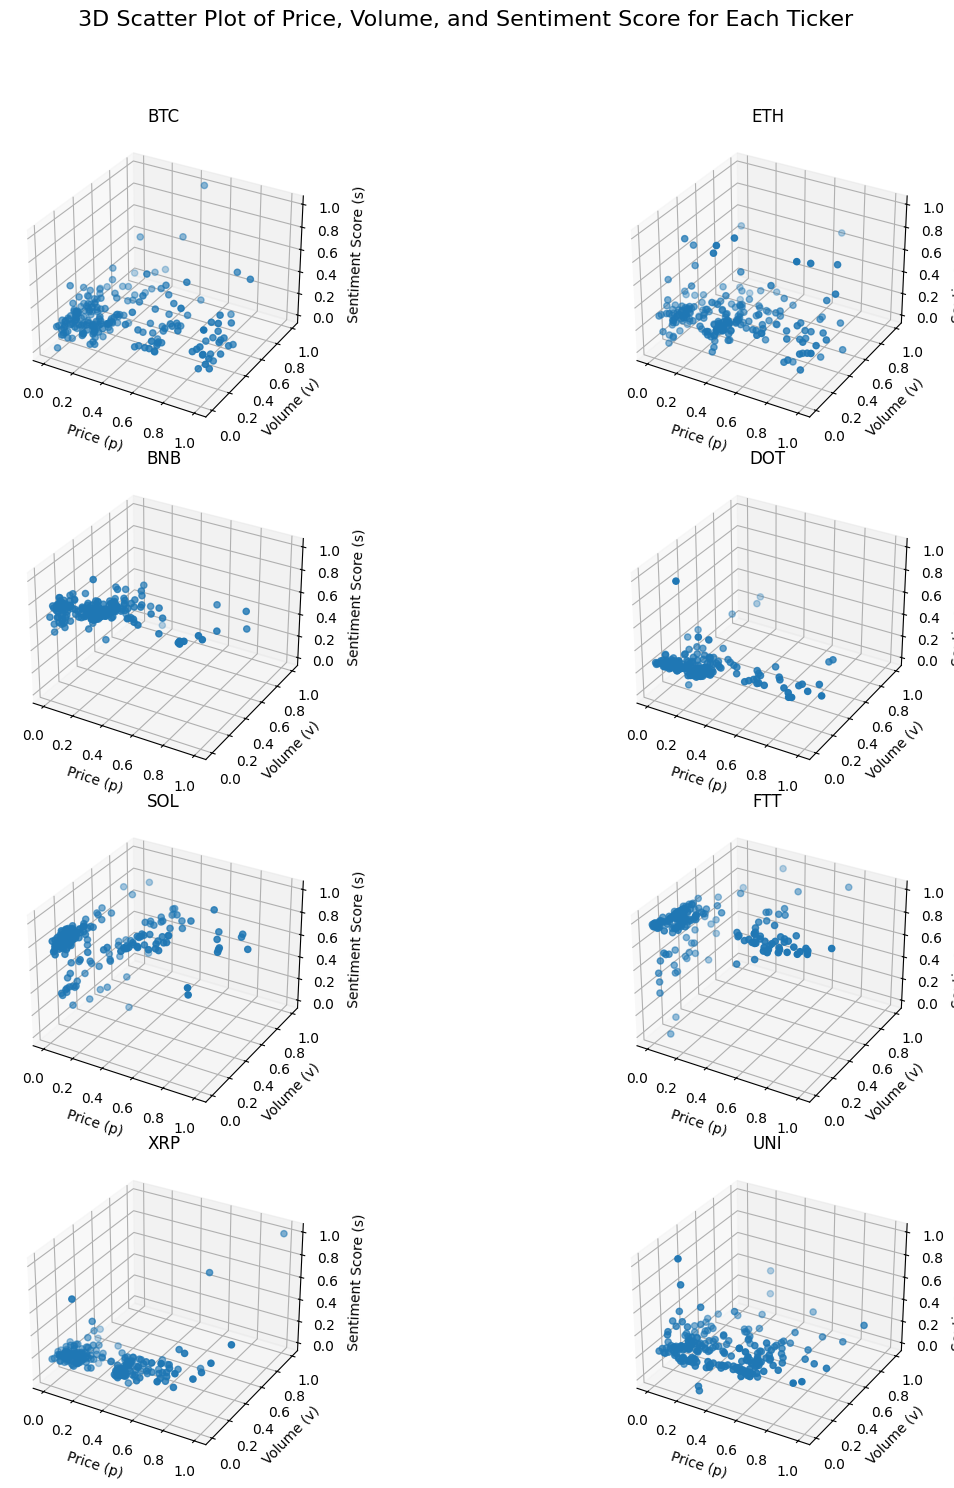

In [16]:

# 3x2 형태의 산포도 그리기
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), subplot_kw={'projection': '3d'})
fig.suptitle('3D Scatter Plot of Price, Volume, and Sentiment Score for Each Ticker', fontsize=16)

# 각 티커별로 그래프 그리기
for idx, (ticker, data) in enumerate(processed_data.items()):
    # 데이터 스케일링
    # scaled_data = scaler.fit_transform(data)
    
    # 서브플롯 위치 계산
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # 각 축에 데이터 플롯
    ax.scatter(data[:, 0], data[:, 1], data[:, 2])
    
    # 축 레이블 설정
    ax.set_xlabel('Price (p)')
    ax.set_ylabel('Volume (v)')
    ax.set_zlabel('Sentiment Score (s)')

    # 그래프 제목 설정
    ax.set_title(ticker)

# 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


#### GPU 설정 확인 및 조정

In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-01-29 15:28:41.791787: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-29 15:28:41.791920: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: user-System-Product-Name
2024-01-29 15:28:41.791936: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: user-System-Product-Name
2024-01-29 15:28:41.792148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.146.2
2024-01-29 15:28:41.792190: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.129.3
2024-01-29 15:28:41.792202: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 535.129.3 does not match DSO version 535.146.2 -- cannot find working devices in this configuration


In [18]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.get_logger().setLevel('ERROR')  # 오류 메시지만 출력하도록 설정

# 모든 GPU에 대해 메모리 성장 설정 적용
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


#### LSTM 모델 설정

In [19]:
### LSTM 모델 불러오기
input_data = np.reshape(data, (1, 1, -1))
input_size = 4
lstm_units = 50 # 초기 셀의 개수 설정

def initialize_ecm_lstm(input_size, lstm_units):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(None, input_size)))
    model.add(Dense(1))  # 예측할 값이 1차원 (예: 수익률)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = initialize_ecm_lstm(input_size, lstm_units)

2024-01-29 15:28:41.828700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **ECM-LSTM 알고리즘**

In [20]:
from tqdm import tqdm
import numpy as np

def ecm_lstm_algorithm2(data, centroids, radiuses, model):
    predicted_returns = []
    initial_centroid = data[0]
    centroids = [initial_centroid]
    radiuses = [0]

    # 데이터 처리 루프
    for t in tqdm(range(len(data)), desc="Processing"):
        new_data = data[t]
        closest_idx = None
        D_min = float('inf')
        S_min_i = float('inf')

        # D_min 계산: 가장 가까운 클러스터 찾기
        for idx, c in enumerate(centroids):
            distance = np.linalg.norm(new_data - c)
            if distance < D_min:
                D_min = distance
                closest_idx = idx

        # S_min,i 계산
        for idx, (c, r) in enumerate(zip(centroids, radiuses)):
            S_min = np.linalg.norm(new_data - c) + r
            if S_min < S_min_i:
                S_min_i = S_min
                closest_idx = idx

        # 클러스터 업데이트
        if closest_idx is not None and D_min <= radiuses[closest_idx]:
            centroids[closest_idx] = (centroids[closest_idx] + new_data) / 2
            radiuses[closest_idx] = max(radiuses[closest_idx], D_min)
        else:
            # 새 클러스터 추가 또는 기존 클러스터 업데이트
            if S_min_i > 2 * radiuses[closest_idx]:
                centroids.append(new_data)
                radiuses.append(D_min)
            else:
                centroids[closest_idx] = (centroids[closest_idx] + new_data) / 2
                radiuses[closest_idx] = max(radiuses[closest_idx], D_min)

        # LSTM 모델을 사용한 예측
        lstm_input_data = np.hstack((new_data, D_min))
        predicted_return = model.predict(np.reshape(lstm_input_data, (1, 1, -1)), verbose=0)
        predicted_returns.append(predicted_return.tolist())

    return centroids, radiuses, predicted_returns


In [22]:
predicted_returns = []
initial_centroid = data[0]
centroids = [initial_centroid]
radiuses = [0]
results = {}
for ticker, data in processed_data.items():
    centroids, radiuses, predicted_returns = ecm_lstm_algorithm2(data, centroids, radiuses, model)
    results[ticker] = {
        'centroids': centroids,
        'radiuses': radiuses,
        'predicted_returns': predicted_returns
    }

# 결과 출력
for ticker, result in results.items():
    print(f"Ticker: {ticker}")
    print("Centroids 개수:", len(result['centroids']))
    # print("Radiuses:", result['radiuses'])
    print("Predicted Returns:", result['predicted_returns'])
    print()


Processing: 100%|██████████| 214/214 [00:08<00:00, 23.97it/s]

Ticker: BTC
Centroids 개수: 46
Predicted Returns: [[[0.06914792209863663]], [[0.06835680454969406]], [[0.0563688650727272]], [[0.06161361187696457]], [[0.07448333501815796]], [[0.05516387149691582]], [[0.07711831480264664]], [[0.0753665417432785]], [[0.09501373767852783]], [[0.0746850073337555]], [[0.06841985881328583]], [[0.06050405651330948]], [[0.06260006874799728]], [[0.05790482833981514]], [[0.06559713929891586]], [[0.07335753738880157]], [[0.060638923197984695]], [[0.06482566893100739]], [[0.0553649477660656]], [[0.05261198431253433]], [[0.0289818923920393]], [[0.0824090987443924]], [[0.07605551183223724]], [[0.06424708664417267]], [[0.05812414363026619]], [[0.053533438593149185]], [[0.0577038936316967]], [[0.03936747461557388]], [[0.072309710085392]], [[0.06189291924238205]], [[0.05273992568254471]], [[0.05281786993145943]], [[0.04552966728806496]], [[0.0386556014418602]], [[0.043456681072711945]], [[0.05124001204967499]], [[0.06573913246393204]], [[0.03317929059267044]], [[0.0483

#### 블랙리터만 제작을 위해 predicted returns 분리 후 pickle로 같은 디렉토리에 저장

In [26]:
# 각 티커별 predicted returns를 저장할 딕셔너리
predicted_returns_by_ticker = {}

for ticker, result in results.items():
    predicted_returns_by_ticker[ticker] = result['predicted_returns']

# 결과 출력
for ticker, predicted_returns in predicted_returns_by_ticker.items():
    print(f"Ticker: {ticker}")
    print("Predicted Returns:", predicted_returns)
    print()

Ticker: BTC
Predicted Returns: [[[0.06914792209863663]], [[0.06835680454969406]], [[0.0563688650727272]], [[0.06161361187696457]], [[0.07448333501815796]], [[0.05516387149691582]], [[0.07711831480264664]], [[0.0753665417432785]], [[0.09501373767852783]], [[0.0746850073337555]], [[0.06841985881328583]], [[0.06050405651330948]], [[0.06260006874799728]], [[0.05790482833981514]], [[0.06559713929891586]], [[0.07335753738880157]], [[0.060638923197984695]], [[0.06482566893100739]], [[0.0553649477660656]], [[0.05261198431253433]], [[0.0289818923920393]], [[0.0824090987443924]], [[0.07605551183223724]], [[0.06424708664417267]], [[0.05812414363026619]], [[0.053533438593149185]], [[0.0577038936316967]], [[0.03936747461557388]], [[0.072309710085392]], [[0.06189291924238205]], [[0.05273992568254471]], [[0.05281786993145943]], [[0.04552966728806496]], [[0.0386556014418602]], [[0.043456681072711945]], [[0.05124001204967499]], [[0.06573913246393204]], [[0.03317929059267044]], [[0.0483611524105072]], [

In [27]:
with open('/home/user/exercise_j/GPT Project/Sentiment-Portfolio-Asset-allocation/Black_Litterman/q_vector.pkl', 'wb') as f:
    pickle.dump(predicted_returns_by_ticker, f)

#### 각 t 시점(하루 단위) 예상 수익률 $Q_t$ => 리스트 형태인 'predicted_returns'에 저장

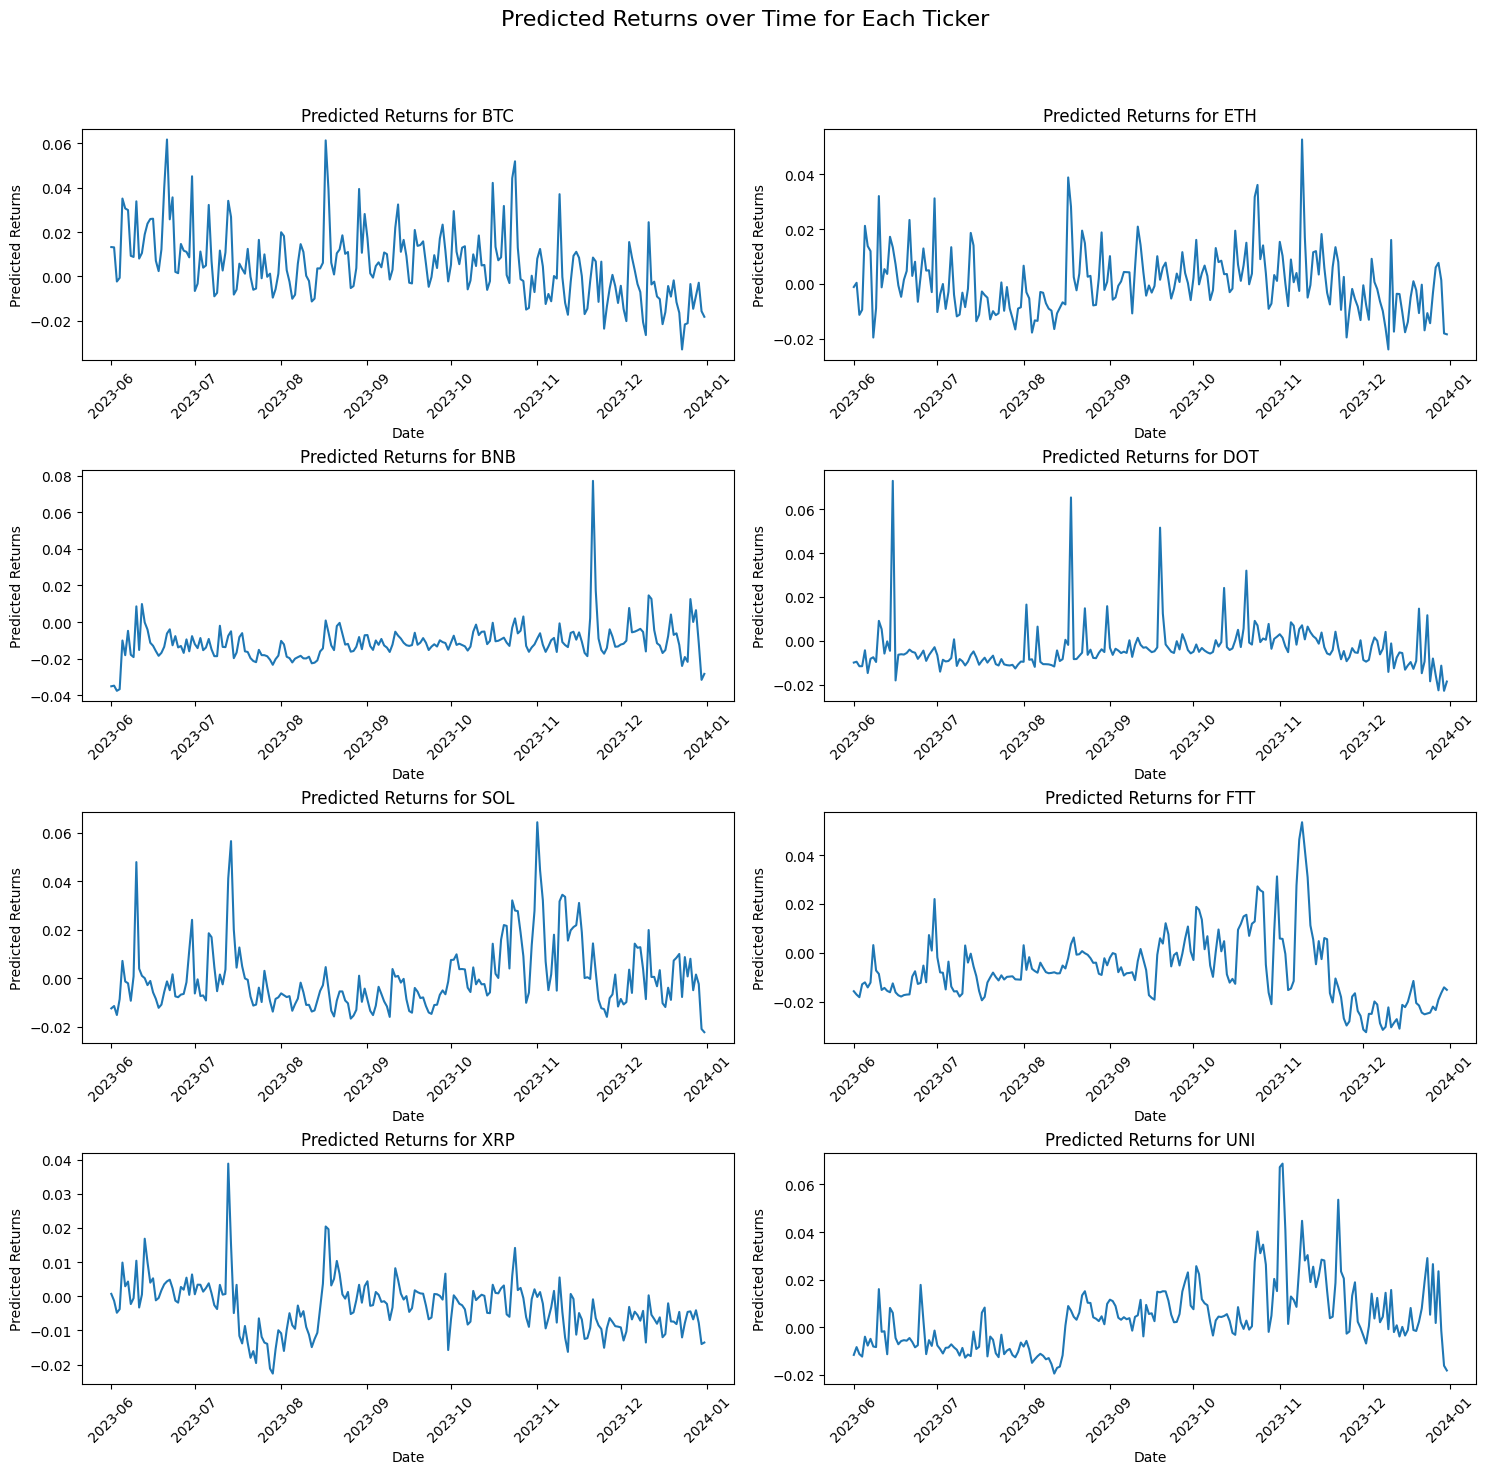

In [51]:
import matplotlib.pyplot as plt

# 3x2 형태의 그래프 그리기
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.suptitle('Predicted Returns over Time for Each Ticker', fontsize=16)

# 각 티커별로 그래프 그리기
for idx, (ticker, result) in enumerate(results.items()):
    # 예측값을 1차원 리스트로 변환
    predicted_values = [val[0] for val in result['predicted_returns']]

    # 서브플롯 위치 계산
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    # 그래프 그리기
    ax.plot(filtered_dfs[ticker]['created_at'], predicted_values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Predicted Returns')
    ax.set_title(f'Predicted Returns for {ticker}')
    ax.tick_params(axis='x', rotation=45)

# 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

